# Full age comparison

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib
from tqdm import trange

import astropy.stats as aps
from astropy.io import fits

import aviary as av

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load data sets.

Isochrone comparison.

In [2]:
xd = pd.read_csv("xd.csv")

All kinematics.

In [4]:
df = pd.read_csv("../all_rvs.csv")
m = np.isfinite(df.color_teffs.values) & np.isfinite(df.Prot.values) & np.isfinite(df.abs_G.values) & np.isfinite(df.all_vz.values)
df = df.iloc[m]

Asteroseismic

In [169]:
# Load asteroseismic stars.
ast1 = pd.read_csv("../../data/vanSaders.txt")
# a_prot, a_teff, a_age = ast.period.values, ast.teff.values, ast.AMP_age.values

# Load Gaia-Kepler crossmatch.
with fits.open("../../data/kepler_dr2_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")
ast = pd.merge(ast1, gaia, how="left", left_on="KIC", right_on="kepid", suffixes=["_vansaders", ""])
print(np.shape(ast))

def abs_g(m, D):
    """
    m - M = 5log(D) - 5
    M = m - 5log(D) + 5
    """
    return m - 5*np.log10(D) + 5

ast["MG"] = abs_g(ast.phot_g_mean_mag.values, (1./ast.parallax.values)*1e3)

(21, 120)


White dwarf.

In [102]:
wd1 = pd.DataFrame(dict({"kepid": [12456401, 11075611], "age": [3.59, 3.64], "prot": [28.901, 47.340], "teff": [3610.0, 3408.0]}))
wd = pd.merge(wd1, df, how="left", on="kepid", suffixes=["_wd", ""])
print(np.shape(wd))

(2, 206)


Clusters and other asteroseismic.

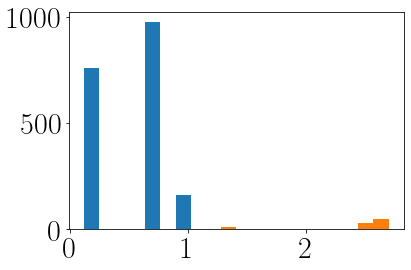

In [7]:
clusters = pd.read_csv("../../data/gyro_clusters_draft-2020April08.csv")
clusters.head()
# prot, teff, age_gyr = clusters.PROT.values, clusters.TEFF.values, clusters.AGE.values*1e-3
H, bins, _ = plt.hist(clusters.AGE.values*1e-3, 20, zorder=0);
clusters = clusters.iloc[clusters.AGE.values*1e-3 > 1]
plt.hist(clusters.AGE.values*1e-3, bins, zorder=10);

In [8]:
benchmark = pd.read_csv("../../data/curtis.csv", skiprows=51)
# b_prot, b_teff, b_age = benchmark.prot.values, benchmark.teff.values, benchmark.age.values

Define kinematic age functions.

In [32]:
def calc_dispersion_bins(teffs, prots, mags, vs, teffrange, protrange, magrange):
    dispersions = np.zeros(len(teffs))
    for i in trange(len(teffs)):
        mask = make_mask([teffs[i], prots[i], mags[i]], [teffs, prots, mags], [teffrange, protrange, magrange])
        vbin = vs[mask]
        dispersions[i] = 1.5*aps.median_absolute_deviation(vbin, ignore_nan=True)
    return dispersions

def make_mask(targets, all_stars, ranges):
    ndim = len(targets)
    bounds = []
    m = np.ones(len(all_stars[0]), dtype=bool)
    for i in range(ndim):
        upper_bound = targets[i] + ranges[i]/2.
        lower_bound = targets[i] - ranges[i]/2.
        m &= (lower_bound < all_stars[i]) & (all_stars[i] < upper_bound)
    return m

def calc_dispersion_target(target_teff, target_prot, target_mag, teffs, prots, mags, vels, teffrange, protrange, magrange):
    dispersions = np.zeros(len(target_teff))
    for i in trange(len(target_teff)):
        mask = make_mask([target_teff[i], target_prot[i], target_mag[i]], [teffs, prots, mags], [teffrange, protrange, magrange])
        mask2 = np.isfinite(vels[mask])
        if len(vels[mask][mask2]) > 0:
            dispersions[i] = 1.5*aps.median_absolute_deviation(vels[mask][mask2], ignore_nan=True)
    return dispersions

def calc_dispersion_target_2D(target_teff, target_prot, teffs, prots, vels, teffrange, protrange):
    dispersions = np.zeros(len(target_teff))
    for i in trange(len(target_teff)):
        mask = make_mask([target_teff[i], target_prot[i]], [teffs, prots], [teffrange, protrange])
        mask2 = np.isfinite(vels[mask])
        if len(vels[mask][mask2]) > 0:
            dispersions[i] = 1.5*aps.median_absolute_deviation(vels[mask][mask2], ignore_nan=True)
    return dispersions

In [95]:
dispersions = calc_dispersion_bins(df.color_teffs.values, np.log10(df.Prot.values), df.abs_G.values, df.all_vz.values, 200, .4, .5)
# dispersions = calc_dispersion_bins(df.color_teffs.values, np.log10(df.Prot.values), df.abs_G.values, df.all_vz.values, 100, .4, .4)

100%|██████████| 31180/31180 [00:06<00:00, 4697.68it/s]


In [92]:
p_mp, p_mr, p_a = av.get_avr_coefficients()
kin_ages = av.v_to_age(dispersions, p_mr)

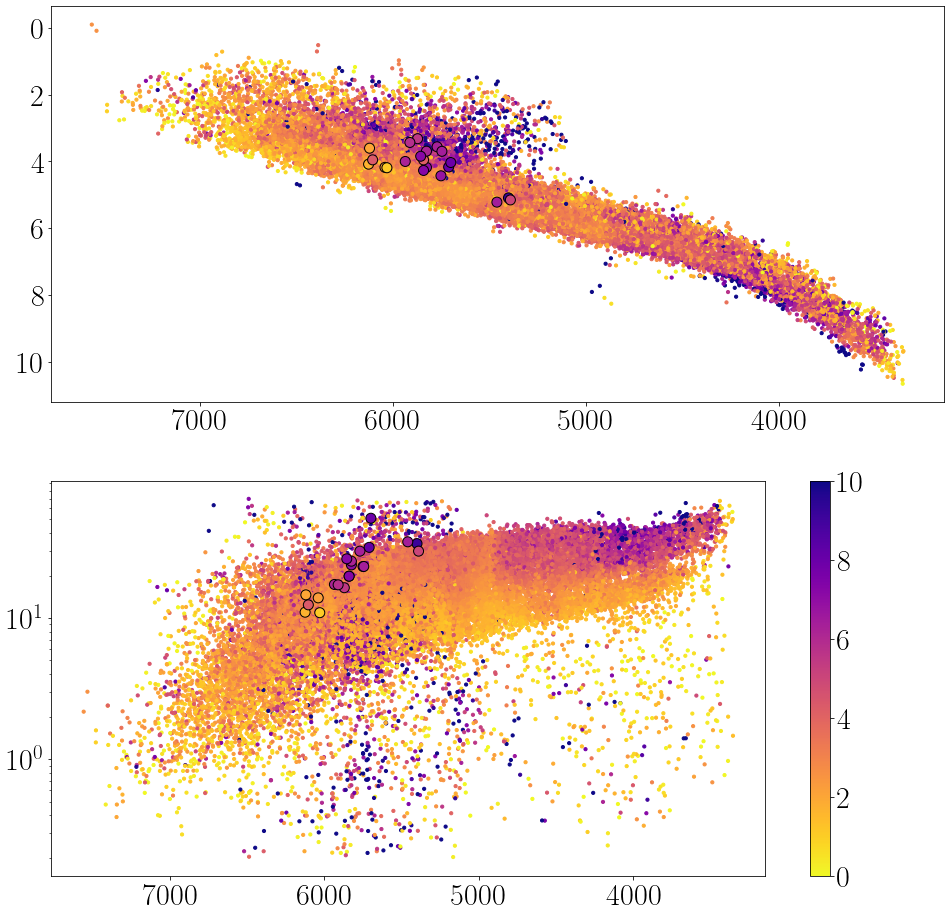

In [94]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(211)
# ax1.scatter(df.bprp_dered, df.abs_G, c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")
# ax1.scatter(ast.phot_bp_mean_mag - ast.phot_rp_mean_mag, ast.MG, c=ast.AMP_age, s=100, edgecolor="k", vmin=0, vmax=10, cmap="plasma_r")
ax1.scatter(df.color_teffs, df.abs_G, c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")
ax1.scatter(ast.teff_vansaders, ast.MG, c=ast.AMP_age, s=100, edgecolor="k", vmin=0, vmax=10, cmap="plasma_r")
ax1.invert_yaxis()
ax1.invert_xaxis()
ax2 = fig.add_subplot(212)
cb = ax2.scatter(df.color_teffs, df.Prot, c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")
ax2.scatter(ast.teff_vansaders, ast.period, c=ast.AMP_age, s=100, edgecolor="k", vmin=0, vmax=10, cmap="plasma_r")
ax2.invert_xaxis()
ax2.set_yscale("log")
plt.colorbar(cb)

In [82]:
astero_disp = calc_dispersion_target(ast.teff_vansaders.values, np.log10(ast.period.values), ast.MG.values,
                                     df.color_teffs, np.log10(df.Prot.values), df.abs_G.values, df.all_vz.values,
                                     100, .4, .4)
# astero_disp = calc_dispersion_target_2D(ast.teff_vansaders.values, np.log10(ast.period.values),
#                                      df.color_teffs, np.log10(df.Prot.values), df.all_vz.values,
#                                      300, .5)

100%|██████████| 21/21 [00:00<00:00, 767.57it/s]


In [161]:
wd_disp = calc_dispersion_target(wd.color_teffs.values, np.log10(wd.prot.values), wd.abs_G.values,
                               df.color_teffs, np.log10(df.Prot.values), df.abs_G.values, df.all_vz.values,
                               120, .5, .2)

100%|██████████| 2/2 [00:00<00:00, 490.91it/s]


In [370]:
bench_disp = calc_dispersion_target_2D(benchmark.teff.values, np.log10(benchmark.prot.values),
                                       df.color_teffs, np.log10(df.Prot.values), df.all_vz.values,
                                       200, .2)
cluster_disp = calc_dispersion_target_2D(clusters.TEFF.values, np.log10(clusters.PROT.values),
                                         df.color_teffs, np.log10(df.Prot.values), df.all_vz.values,
                                         300, .2)

100%|██████████| 91/91 [00:00<00:00, 1069.68it/s]


In [371]:
def chi2(y1, y2, yerr):
    return sum((y1 - y2)**2/yerr**2)

astero_kin_age = av.v_to_age(astero_disp, p_mr)
wd_kin_age = av.v_to_age(wd_disp, p_mr)
bench_kin_age = av.v_to_age(bench_disp, p_mr)
cluster_kin_age = av.v_to_age(cluster_disp, p_mr)

# print(chi2(wd_kin_age, wd.age_wd, np.ones_like(wd_kin_age)))
# print(chi2(cluster_kin_age, clusters.AGE.values*1e-3, np.ones_like(cluster_kin_age)))
print(chi2(bench_kin_age, benchmark.age, np.ones_like(bench_kin_age)))

13.387496144052562


Text(0, 0.5, 'Kinematic age')

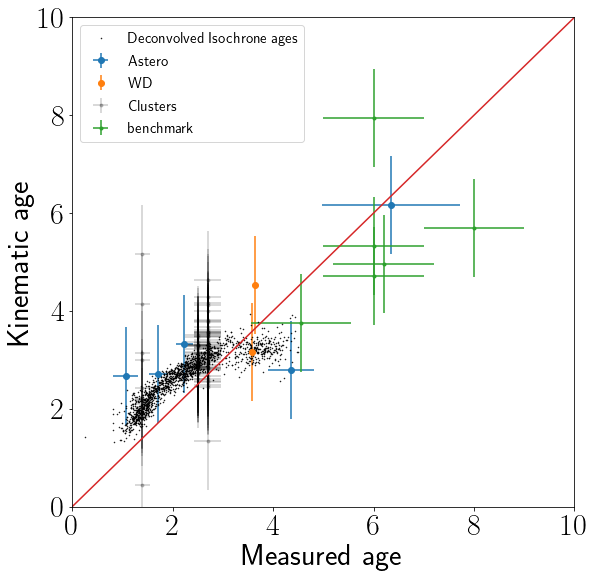

In [388]:
plt.figure(figsize=(9, 9))

pred_period = 10**gk_rotation_model(np.log10(ast.AMP_age.values*1e9), ast.phot_bp_mean_mag - ast.phot_rp_mean_mag)
diff = (abs(pred_period - ast.period.values))
m = diff < 5

# Asteroseismic stars.
xs = np.linspace(0, 10, 100)
plt.errorbar(ast.AMP_age[m], astero_kin_age[m], xerr=ast.AMP_age_err[m], yerr=np.ones_like(astero_kin_age[m]), fmt="o", label="Astero")
# plt.errorbar(ast.AMP_age, astero_kin_age, xerr=ast.AMP_age_err, yerr=np.ones_like(astero_kin_age), fmt="o", label="Astero")
# plt.scatter(ast.AMP_age[m], astero_kin_age[m], c=diff[m], zorder=10)
# plt.colorbar()

# axe = np.array([8006161, 12069424, 12069449, 3656476, 5184732, 6196457, 6521045, 7680114, 9098294, 11244118, 6116048,
#                 10963065, 11401755])
# for i in range(len(ast.AMP_age)):
#     if ast.KIC.values[i] not in axe:
#         plt.errorbar(ast.AMP_age.values[i], astero_kin_age[i], xerr=ast.AMP_age_err.values[i],
#                      yerr=np.ones_like(astero_kin_age[i]), fmt="ro")
# # plt.scatter(ast.AMP_age, astero_kin_age, c=ast.AMP_logg, zorder=10)
# # plt.colorbar()

plt.errorbar(wd.age_wd, wd_kin_age, yerr=np.ones_like(wd_kin_age), fmt="o", label="WD")

plt.errorbar(clusters.AGE*1e-3, cluster_kin_age, xerr=clusters.AGE*1e-4, yerr=np.ones_like(cluster_kin_age),
             fmt="k.", alpha=.2, label="Clusters")

plt.errorbar(benchmark.age, bench_kin_age, yerr=np.ones_like(bench_kin_age), xerr=np.ones_like(bench_kin_age),
             fmt=".", label="benchmark")

xd = pd.read_csv("../../data/xd_results.csv")
xm = (xd.iso_age.values < 4.5) & (xd.kin_age.values < 4) 
plt.plot(xd.iso_age.values[xm], xd.kin_age.values[xm], "k.", ms=1, label="Deconvolved Isochrone ages")

plt.legend()
plt.plot(xs, xs)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Measured age")
plt.ylabel("Kinematic age")

No handles with labels found to put in legend.


Text(0, 0.5, 'Kinematic age')

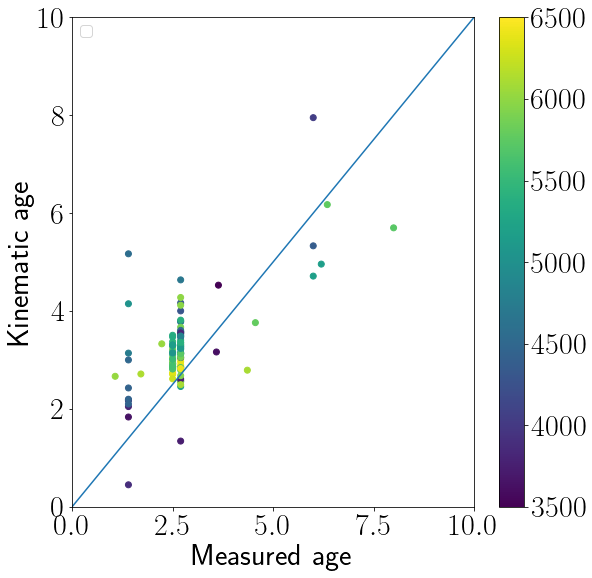

In [391]:
plt.figure(figsize=(9, 9))
vmin, vmax = 3500, 6500
plt.scatter(ast.AMP_age[m], astero_kin_age[m], c=ast.teff_vansaders[m], vmin=vmin, vmax=vmax)
plt.scatter(wd.age_wd, wd_kin_age, c=wd.teff, vmin=vmin, vmax=vmax)
plt.scatter(clusters.AGE*1e-3, cluster_kin_age, c=clusters.TEFF, vmin=vmin, vmax=vmax)
plt.scatter(benchmark.age, bench_kin_age, c=benchmark.teff, vmin=vmin, vmax=vmax)
# plt.scatter(xd.iso_age.values[xm], xd.kin_age.values[xm], c=np.ones_like(xd.kin_age.values[xm])*6000, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.legend()
xs = np.linspace(0, 10, 100)
plt.plot(xs, xs)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Measured age")
plt.ylabel("Kinematic age")

In [246]:
from stardate.lhf import gk_rotation_model
from kinematics_and_rotation.photometric_teff import bprp_to_teff

5993.6167852265735


For each star, what is the difference between the period and the expected period at that color and teff?

5897.874466291198
6191.250403648134
[ 6116048 10963065 11401755]


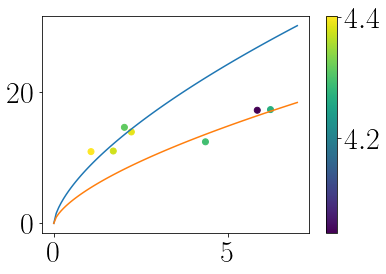

In [312]:
xs_bprp = .78
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
ages = np.linspace(0, 7, 100)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

xs_bprp = .69
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

tm = (5900 < ast.teff_vansaders.values) & (ast.teff_vansaders.values < 6200)
plt.scatter(ast.AMP_age.values[tm], ast.period.values[tm], c=ast.AMP_logg.values[tm])
plt.colorbar()

# low = ast.AMP_age.values[tm] > 5
# print(ast.KIC.values[tm][low])

print(ast.KIC.values[tm][ast.AMP_age.values[tm]> 3.5])

5594.398729557282
5897.874466291198
[12069424 12069449  3656476  5184732  6196457  6521045  7680114  9098294
 11244118]


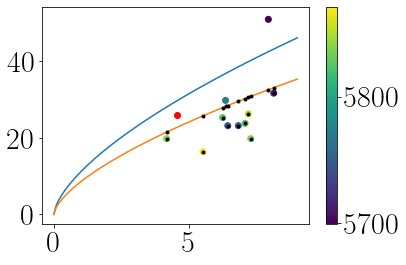

In [305]:
xs_bprp = .88
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
ages = np.linspace(0, 9, 100)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

xs_bprp = .78
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

tm = (5600 < ast.teff_vansaders.values) & (ast.teff_vansaders.values < 5900)
plt.plot(4.56, 26, "ro")
plt.scatter(ast.AMP_age.values[tm], ast.period.values[tm], c=ast.teff_vansaders.values[tm])
plt.colorbar()

# Get rid of those anomalous stars
axe_prots = 10**gk_rotation_model(np.log10(ast.AMP_age.values[tm]*1e9), xs_bprp)
plt.plot(ast.AMP_age.values[tm], axe_prots, "k.")
axe_mask = ast.period.values[tm] < axe_prots
_axe = ast.KIC.values[tm][axe_mask]
plt.plot(ast.AMP_age.values[tm][axe_mask], ast.period.values[tm][axe_mask], "k.")
print(_axe)

5113.0077549724165
5397.007165759355
[8006161]


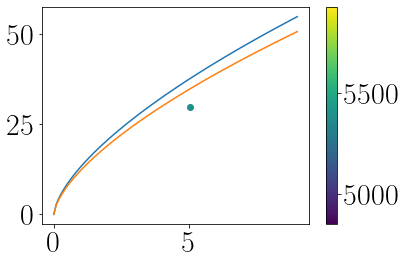

In [300]:
xs_bprp = 1.06
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
ages = np.linspace(0, 9, 100)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

xs_bprp = .95
xs_teff = bprp_to_teff(xs_bprp)
print(xs_teff)
prots = 10**gk_rotation_model(np.log10(ages*1e9), xs_bprp)
plt.plot(ages, prots)

tm = (5100 < ast.teff_vansaders.values) & (ast.teff_vansaders.values < 5400)
plt.scatter(ast.AMP_age.values[tm], ast.period.values[tm], c=ast.teff_vansaders.values[tm])
plt.colorbar()
print(ast.KIC.values[tm])

In [ ]:
axe = np.array([8006161, 12069424, 12069449, 3656476, 5184732, 6196457, 6521045, 7680114, 9098294, 11244118, 6116048,
                10963065, 11401755])